# 1. Data Importing

In [121]:
import imutils
from imutils import face_utils
import time
import dlib
import cv2
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import torch.utils.data as utils_data
import torch
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torchvision.models as models

In [17]:
data_path = 'dataset/ck/'
df = pd.read_csv(data_path + 'df_vector_coods_sep.csv', index_col='filename')
df['vectors'] = df['vectors'].apply(json.loads)
df['coords'] = df['coords'].apply(json.loads)
df = df[df.mood != "contempt"] # drop contempt values
display(df.sample(10))

,mood,vectors,coords
filename,,,
S042_005_00000001.png,neutral,"[[0.9396970637153027, -2.6283403807235324], [0...","[-0.818619173037878, -0.4614035338940767, -0.8..."
S502_004_00000052.png,fear,"[[0.9300919091909519, -2.7076392841958965], [0...","[-0.8438822542602048, -0.39106738612058267, -0..."
S125_007_00000009.png,surprise,"[[0.883967117034858, -2.677945044588987], [0.8...","[-0.7906442254257819, -0.39532211271289097, -0..."
S029_001_00000019.png,anger,"[[0.93637599285757, -2.704965493776252], [0.84...","[-0.848528137423857, -0.3959797974644666, -0.8..."
S014_001_00000029.png,surprise,"[[0.9040298402309024, -2.562185826868176], [0....","[-0.756480938543342, -0.49498135484934724, -0...."
S093_003_00000001.png,neutral,"[[0.9792097885309108, -2.7159701852501614], [0...","[-0.8918465515396763, -0.40430377003131995, -0..."
S065_004_00000001.png,neutral,"[[0.9661523518888342, -2.666249671423298], [0....","[-0.8590406543549981, -0.44215327797683723, -0..."
S092_004_00000001.png,neutral,"[[0.9341736521499278, -2.688814181766257], [0....","[-0.8400417269950248, -0.4086689482678499, -0...."
S088_004_00000020.png,disgust,"[[0.9977122491638168, -2.6728945824799144], [0...","[-0.8901161248706423, -0.45069170879526194, -0..."


# 2. Build Model

In [249]:
class GenericModel(object):
    def __init__(self, path, cuda):
        self.path = path
        self.model = None
        self.cuda = cuda
        
    def build(self, model, opt, lr):
        self.model = model        
        if self.cuda and torch.cuda.is_available():
            self.model = self.model.cuda()
        if opt.lower() == 'adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=0.0001)
        elif opt.lower() == 'sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, weight_decay=0.0001)
        self.loss_func = nn.CrossEntropyLoss()
        print("Model built.")
        
    def train(self, loaders, attr, grad_clip, epochs, print_epoch, save):
        self.epochs = epochs
        train_loader, test_loader = loaders[0], loaders[1]
        self.train_losses, self.test_losses = [], []
        self.train_accuracies, self.test_accuracies = [], []
        
        global best_accuracies
        if best_accuracies.get(attr) is None:
            best_accuracies[attr] = 0
            
        train_size = len(train_loader.dataset)
        test_size = len(test_loader.dataset)
        
        tic = time.time()
        print("Starting training...")
            
        for epoch in range(self.epochs): # 200
            running_loss, ev_loss = 0.0, 0.0
            train_acc = 0.0
            for step, (batch_image, batch_label) in enumerate(train_loader):
                self.model.train()
                if self.cuda and torch.cuda.is_available():
                    batch_image, batch_label = batch_image.cuda(), batch_label.cuda()
                batch_output = self.model(batch_image)
                batch_loss = self.loss_func(batch_output, batch_label)

                self.optimizer.zero_grad()
                batch_loss.backward()
                
                if grad_clip:
                    nn.utils.clip_grad_value_(self.model.parameters(), grad_clip)
                
                self.optimizer.step()
                self.optimizer.zero_grad()

                running_loss += batch_loss.item()

                # train accuracy
                _, train_predicted = torch.max(batch_output.data, 1)
                train_acc += (train_predicted == batch_label).sum().item()

            train_acc /= train_size
            running_loss /= (step+1)
            self.train_losses.append(running_loss)
            self.train_accuracies.append(train_acc)

            # ----------test----------
            self.model.eval()
            test_acc = 0.0
            for step, (test_image, test_label) in enumerate(test_loader):
                if self.cuda and torch.cuda.is_available():
                    test_image, test_label = test_image.cuda(), test_label.cuda()                
                test_output = self.model(test_image)
                _, predicted = torch.max(test_output.data, dim=1)
                test_acc += (predicted == test_label).sum().item()

                batch_loss = self.loss_func(test_output, test_label)
                ev_loss += batch_loss.item()

            test_acc /= test_size
            ev_loss /= (step+1)
            self.test_losses.append(ev_loss)
            self.test_accuracies.append(test_acc)

            if (not (epoch % print_epoch)) or (epoch == epochs-1):
                print('epoch={:d}\ttrain loss={:.6f}\ttest loss={:.6f}\ttrain accuracy={:.3f}\ttest accuracy={:.3f}'.format(
                    epoch, running_loss, ev_loss, train_acc, test_acc))

            if save:
                if test_acc >= best_accuracies[attr]:
                    torch.save(self.model.state_dict(), self.path)
                    best_accuracies[attr] = test_acc
                    
        toc = time.time()
        tt = toc - tic
        print("Done. Time taken: %dm%ds." % (tt//60, tt%60))
                
    def visualize(self, figsize, loss_range, acc_range, title):
        loss_range = loss_range if loss_range else self.epochs
        acc_range = acc_range if acc_range else self.epochs
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(figsize[0], figsize[1])
        fig.suptitle(title)
        ax1.set_title("Cross Entropy Loss")
        ax1.plot([k for k in range(self.epochs)], self.train_losses, label="train: %.3f" % self.train_losses[-1])
        ax1.plot([k for k in range(self.epochs)], self.test_losses, label="test: %.3f" % self.test_losses[-1])
        ax1.set_xlim(0,loss_range)
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.legend(loc='upper right')

        ax2.set_title("Accuracy")
        ax2.plot([k for k in range(self.epochs)], self.train_accuracies, label="train: %.3f" % self.train_accuracies[-1])
        ax2.plot([k for k in range(self.epochs)], self.test_accuracies, label="test: %.3f" % self.test_accuracies[-1])
        ax2.set_xlim(0,acc_range)
        ax2.set_ylim(0,1.1)
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.legend(loc='lower right')

## 2a. FCNN

In [226]:
class FCNNModel(Module):
    def __init__(self, *args, **kwargs):
        super(FCNNModel, self).__init__()
        
        input_layer_size = kwargs['input_layer_size']
        hidden_layer_size = kwargs['hidden_layer_size']
        num_classes = kwargs['num_classes']
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, num_classes),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [227]:
class VectorModel(GenericModel):
    def __init__(self, cuda=True, hidden_layer_size=512):
        self.hidden_layer_size = hidden_layer_size
        path = './trained_models/FCNN_state_dicts/FCNN_model-%d.pkl' % self.hidden_layer_size
        super().__init__(path, cuda)
        
    def build(self, input_layer_size, num_classes, lr=0.001):
        model = FCNNModel(input_layer_size=input_layer_size, hidden_layer_size=self.hidden_layer_size, num_classes=num_classes)
        super().build(model, opt='adam', lr=lr)
        
    def train(self, loaders, epochs=200, print_epoch=50, save=True):
        attr = self.hidden_layer_size
        super().train(loaders, attr, grad_clip=False, epochs, print_epoch, save)
        
    def visualize(self, figsize=(12,3.6), loss_range=0, acc_range=0):
        title = 'Hidden layer size: %d' % self.hidden_layer_size
#         label = "test: %.3f" % best_accuracies[self.hidden_layer_size]
        super().visualize(figsize, loss_range, acc_range, title)

## 2b. CNN

In [250]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class CNNModel(Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        self.conv1 = conv_block(1, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))    

    # Defining the forward pass    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [252]:
class ImageModel(GenericModel):
    def __init__(self, key, cuda=False):
        self.name = "CNNModel%d" % key
        path = './trained_models/CNNModels/%s.pkl' % self.name
        super().__init__(path, cuda)
        
    def build(self, num_classes, lr=1e-5):
        model = CNNModel(num_classes)
        super().build(model, opt="sgd", lr=lr)
        
    def train(self, loaders, grad_clip=0.1, epochs=200, print_epoch=50, save=True):
        attr = self.name
        super().train(loaders, attr, grad_clip, epochs, print_epoch, save)
        
    def visualize(self, figsize=(12,3.6), loss_range=0, acc_range=0):
#         title = self.name
#         label = "test: %.3f" % best_accuracies[self.hidden_layer_size]
        super().visualize(figsize, loss_range, acc_range, self.name)

# 3. Load Data

In [166]:
moods = ["anger","disgust","fear","happiness","neutral","sadness","surprise"]
mood_map = { moods[k]:k for k in range(len(moods)) } # mood : index
mood_map.update({ k:moods[k] for k in range(len(moods)) }) # index : mood

In [167]:
def get_dataloaders(data, label, split_ratio=0.8):
    dataset_size = data.shape[0]
    train_size = int(split_ratio * dataset_size)
    test_size = dataset_size - train_size

    dataset = utils_data.TensorDataset(torch.Tensor(data), torch.LongTensor(label))
    train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
    batch_size = 8
    train_loader = utils_data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = utils_data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
    print('Data is ready!')
    
    return train_loader, test_loader

Vectors

In [39]:
num_samples = df.shape[0]

vectors = np.array([k for k in df['vectors'].values]).reshape(num_samples, -1)
coords = np.array([k for k in df['coords'].values])
Vector = np.dstack((vectors, coords)).reshape(num_samples, -1) # shape=(samples, vectors+coords)

y = df.loc[:,"mood"].values
Label = np.array([float(mood_map[k]) for k in y])

vector_train_loader, vector_test_loader = get_dataloaders(Vector, Label)

Graylevels

In [168]:
Image = cropped_dataset/255.0
Label = np.array([float(mood_map[k]) for k in cropped_target])
px_train_loader, px_test_loader = get_dataloaders(Image, Label)

Data is ready!


# 4. Train & Evaluate Model

## A. FCNN

In [36]:
def add_fcnn_model(models, hidden_layer_size, save=True):
    print("hidden_layer_size: %d" % hidden_layer_size)
    inst = VectorModel(cuda=True, hidden_layer_size)
    inst.build(input_layer_size, num_classes)
    inst.train((vector_train_loader, vector_test_loader), epochs=200, print_epoch=100, save=save)
    print()
    if save:
        inst.model.load_state_dict(torch.load(inst.path)) # best model
    models[hidden_layer_size] = inst
    return models

In [112]:
input_layer_size = Vector.shape[1]
num_classes = len(moods)
best_accuracies = {}
fcnn_models = {}

In [ ]:
for hidden_layer_size in [16, 32, 64, 128, 256, 512]:
    fcnn_models = add_fcnn_model(fcnn_models, hidden_layer_size)

## B. CNN

In [253]:
def add_cnn_model(models, key, save=False):
    inst = ImageModel(key, cuda=True)
    print(inst.name)
    inst.build(num_classes)
    inst.train((px_train_loader, px_test_loader), epochs=24, print_epoch=1, save=save)
    print()
    if save:
        inst.model.load_state_dict(torch.load(inst.path)) # best model
    models[inst.name] = inst
    return models

In [254]:
num_classes = len(moods)
best_accuracies = {}
cnn_models = {}

In [255]:
cnn_models = add_cnn_model(cnn_models, 1)

CNNModel1
Model built.
Starting training...
epoch=0	train loss=12.775254	test loss=4.081145	train accuracy=0.029	test accuracy=0.022
epoch=1	train loss=11.175466	test loss=4.788153	train accuracy=0.029	test accuracy=0.022
epoch=2	train loss=9.767566	test loss=5.145733	train accuracy=0.029	test accuracy=0.022
epoch=3	train loss=8.233054	test loss=5.417373	train accuracy=0.031	test accuracy=0.022
epoch=4	train loss=6.805314	test loss=5.676093	train accuracy=0.028	test accuracy=0.022
epoch=5	train loss=5.207557	test loss=5.252915	train accuracy=0.037	test accuracy=0.022
epoch=6	train loss=3.860863	test loss=5.664866	train accuracy=0.105	test accuracy=0.022
epoch=7	train loss=2.933281	test loss=5.235126	train accuracy=0.297	test accuracy=0.022
epoch=8	train loss=2.445009	test loss=4.931902	train accuracy=0.467	test accuracy=0.022
epoch=9	train loss=2.101600	test loss=4.596180	train accuracy=0.560	test accuracy=0.022
epoch=10	train loss=1.946311	test loss=4.339735	train accuracy=0.596	test 

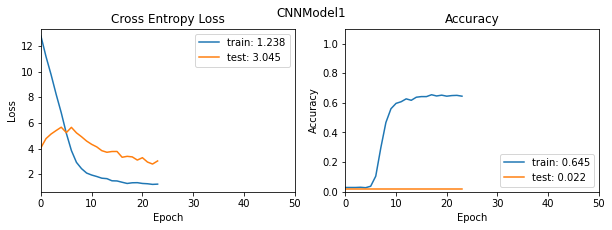

In [256]:
# Visualize model performances
for hl_size, inst in cnn_models.items():
    inst.visualize(figsize=(10,3), loss_range=50, acc_range=50)

In [ ]:
# Compare final losses & accuracies across diff hidden layer sizes
keys = ['Hidden layer size', 'Loss (Train)', 'Loss (Test)', 'Accuracy (Train)', 'Accuracy (Test)']
df_dict = { k:[] for k in keys }

for hl_size, inst in models.items():
    df_dict[keys[0]].append(hl_size)
    df_dict[keys[1]].append(inst.train_losses[-1])
    df_dict[keys[2]].append(inst.test_losses[-1])
    df_dict[keys[3]].append(inst.train_accuracies[-1])
    df_dict[keys[4]].append(best_accuracies[hl_size])
    
df_metrics = pd.DataFrame(df_dict)
df_metrics.set_index(keys[0], inplace=True)
display(df_metrics)

In [ ]:
# Visualize losses & accuracies across diff hidden layer sizes
epochs = 500
targets = ["train_losses", "test_losses", "train_accuracies", "test_accuracies"]
titles = ["Cross Entropy Loss (Train)", "Cross Entropy Loss (Test)", "Accuracy (Train)", "Accuracy (Test)"]
ranges = [500, 500, 500, 500]

fig, axs = plt.subplots(2,2)
fig.set_size_inches(12,8)
# plt.subplots_adjust(top=0.94)

# Training loss
for i in range(4):
    row, col = i // 2, i % 2;
    for hl_size, inst in models.items(): 
        axs[row,col].plot([k for k in range(epochs)], getattr(inst, targets[i]), label="hidden layer size: %d" % hl_size, alpha=0.5)
    axs[row,col].set_title(titles[i])
    axs[row,col].set_xlim(0, ranges[i])
    axs[row,col].set_xlabel("Epoch")
    axs[row,col].set_ylabel("Accuracy" if row else "Loss")
    axs[row,col].legend(loc=("lower right" if row else "upper right"))

fig.tight_layout()
plt.show()

In [ ]:
# save best model
torch.save(dd[128].model, './trained_models/FCNN_model.pt')

# 5. Testing Models

In [143]:
import random
import math

In [144]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [149]:
# Functions for finding vector magnitude and direction
def mag(pointA, pointB):
    x = pointA[0] - pointB[0]
    y = pointA[1] - pointB[1]
    return math.sqrt(x*x + y*y)

# find angle between two points (-pi to pi rads)
def angle(cog, point):
    x = point[0] - cog[0]
    y = point[1] - cog[1]
    
    if not x:
        return math.pi/2 if y>0 else -math.pi/2
        
    angle = math.atan(y/x)
    if x<0 and y>0: # 2nd quadrant
        angle += math.pi
    elif x<0 and y<0: # 3rd quadrant
        angle -= math.pi
    return angle

In [145]:
# get all image filenames
image_filenames = []
for root, dirs, files in os.walk(data_path):
    dirc = os.path.basename(root)
    if dirc != "contempt":
        for file in files:
            image_filenames += [data_path + dirc + '/' + file]        

In [159]:
# load models
fcnn_model = torch.load('./trained_models/FCNN_model.pt')
fcnn_model.eval()
cnn_model = cnn_models['CNNModel1'].model
cnn_model.eval()

CNNModel(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

A: neutral, P(FCNN): neutral, P(CNN): fear


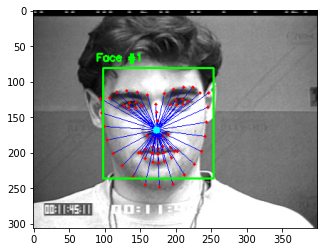

A: neutral, P(FCNN): neutral, P(CNN): fear


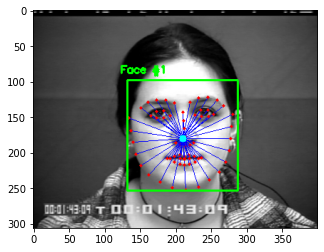

A: happiness, P(FCNN): happiness, P(CNN): fear


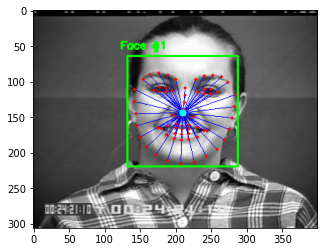

A: neutral, P(FCNN): neutral, P(CNN): fear


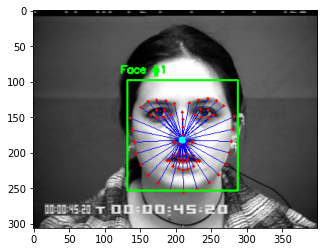

A: fear, P(FCNN): fear, P(CNN): fear


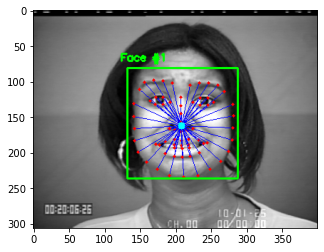

A: happiness, P(FCNN): happiness, P(CNN): fear


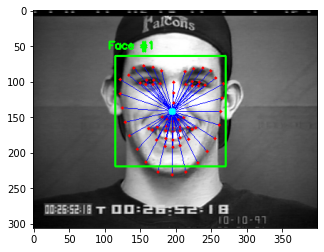

A: neutral, P(FCNN): neutral, P(CNN): fear


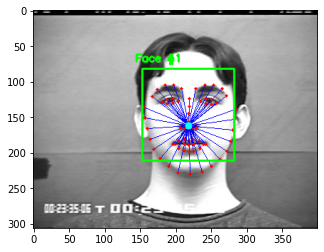

A: happiness, P(FCNN): happiness, P(CNN): fear


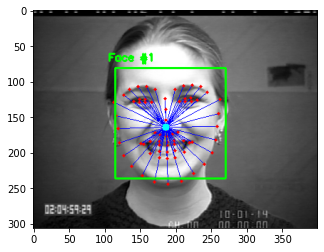

A: anger, P(FCNN): anger, P(CNN): fear


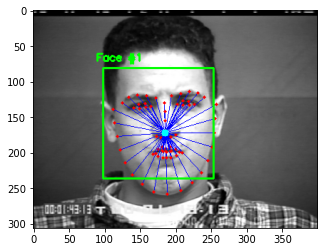

A: neutral, P(FCNN): neutral, P(CNN): fear


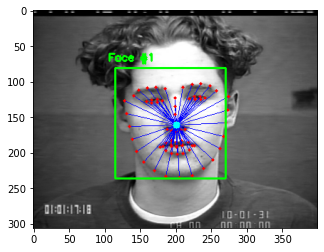

In [163]:
rand_images = random.sample(image_filenames, 10) # get random images  

for path in rand_images:   
    vectors, coords = [], []

    image = cv2.imread(path)
    image = imutils.resize(image, width=400)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    rects = detector(gray, 1)         

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)        

        cog = tuple(shape.mean(axis=0).astype(int)) # get center of gravity (COG)            
        for (x,y) in shape:
            cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
            cv2.circle(image, (x,y), 2, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
            vectors.append([mag(cog, (x,y)), angle(cog, (x,y))]) # get vector magnitude and direction                
            coords.append([x-cog[0], y-cog[1]]) # append coordinates relative to cog
            cv2.circle(image, cog, 5, (0,255,255), -1)    
            
        (x,y,w,h) = face_utils.rect_to_bb(rect) # convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x,y,w,h)]
        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2) # draw the face bounding box
        cv2.putText(image, "Face #{}".format(i+1), (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2) # show face number

    ## vector input
    vectors = np.array(vectors)        
    scale_factor = 1 / max(vectors[:,0])
    vectors[:,0] = vectors[:,0] * scale_factor # normalize magnitudes
    coords = np.array(coords) * scale_factor
    coords = coords.reshape(-1)
    
    ## graylevel input
    dim = 50
    cnn_input = image[y:y+h, x:x+w] # crop to face
    cnn_input = cv2.cvtColor(cnn_input, cv2.COLOR_RGB2GRAY) # convert to grayscale
    cnn_input = cv2.equalizeHist(cnn_input) # equalize histogram
    cnn_input = imutils.resize(cnn_input, width=int(dim*1.05)) # buffer of 5 pixels for cropping to 100x100
    cnn_input = cnn_input[:dim,:dim]
    cnn_input = cnn_input.reshape(1,1,dim,dim) # shape=(1,1,dim,dim)
    
    # prediction
    fcnn_input = np.dstack((vectors.reshape(1, -1), coords)).reshape(1, -1) # shape=(1, 272)
    with torch.no_grad():
        fcnn_pred_tensor = fcnn_model(torch.Tensor(fcnn_input).cuda()).argmax()
        fcnn_pred = fcnn_pred_tensor.cpu().numpy().item()
        cnn_pred_tensor = cnn_model(torch.Tensor(cnn_input).cuda()).argmax()
        cnn_pred = cnn_pred_tensor.cpu().numpy().item()        
    fcnn_pred_label = mood_map[fcnn_pred]
    cnn_pred_label = mood_map[cnn_pred]
#     cv2.putText(image, '%s' % pred_label, (x,y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    
#     print(path)
    true_label = path.split('/')[2]
    print("A: %s, P(FCNN): %s, P(CNN): %s" % (true_label, fcnn_pred_label, cnn_pred_label))
    plt.imshow(image) # adapted for jupyter
    plt.show()